<a href="https://colab.research.google.com/github/VincentNFR/openclassrooms_p06/blob/main/scratch/vgg16/vgg16_from_scratch_config_raw_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

# Import des donneés

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
raw_image_tensor = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/images_reduced.npy', allow_pickle=True)
raw_label_tensor = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/label_reduced.npy', allow_pickle=True)

In [4]:
raw_image_tensor.shape, raw_label_tensor.shape

((1124,), (1124,))

# Evaluation des modèles

In [5]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test, lb):
    ### Predict
    y_pred = [lb.classes_[np.argmax(model.predict(np.expand_dims(_X_test, axis=0)))] for _X_test in X_test]

    #Get the confusion matrix
    cf_matrix = confusion_matrix(lb.inverse_transform(y_test), y_pred)

    plt.figure(figsize=(8,8))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Breed')
    ax.set_ylabel('Expected Breed');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(lb.classes_, rotation=90)
    ax.yaxis.set_ticklabels(lb.classes_, rotation=0)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    ### Scores
    print('\n\n')
    print(classification_report(y_test,lb.transform(y_pred)))

# Preparation des sets

In [6]:
from numpy import expand_dims
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import LabelBinarizer

np.random.seed(1)

image_generator = ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2
    )

def generate_new_image(image, target_size=(224,224), seed=1):
    it = image_generator.flow(expand_dims(image, 0), batch_size=1, seed=seed).next()[0].astype('uint8')
    new_image = resize(it, target_size, anti_aliasing=True)
    return new_image

def normalize(x):
    return x/255.

def generate_dataframe(raw_label_tensor, raw_image_tensor, nb_images_per_class=100, target_size=(224,224)):
    """
    Genere une image à partir du jeu de données
    - Image aléatoire
    - Image resize
    - Image normalisee
    return df['Images','Labels'], Dict(Label: Breed)
    """
    label_unique = np.unique(raw_label_tensor)
    df = pd.DataFrame(columns=['Images', 'Labels'])
    convert_labels = dict()
    for i in trange(len(label_unique), desc='Total set'):
        breed = label_unique[i]
        convert_labels[i] = breed
        imported_image = np.where(raw_label_tensor==breed)[0]
        n_image_to_create = nb_images_per_class - imported_image.shape[0]
        samples = np.where(raw_label_tensor==breed)[0]
        label_arr = np.zeros((len(label_unique)))
        label_arr[i] = 1
        ## Ajout des images existantes
        for k in imported_image:
            resized_image = resize(raw_image_tensor[k], target_size, anti_aliasing=True)
            #df = df.append(dict(zip(df.columns,[resized_image, label_arr])), ignore_index=True)
            df = df.append(dict(zip(df.columns,[resized_image, breed])), ignore_index=True)
        ## Ajout d'image generées
        for j in tqdm(range(n_image_to_create), desc=breed):
            sample_image = raw_image_tensor[np.random.choice(samples)]
            new_image = generate_new_image(sample_image)
            
            #df = df.append(dict(zip(df.columns,[new_image, label_arr])), ignore_index=True)
            df = df.append(dict(zip(df.columns,[new_image, breed])), ignore_index=True)
    df['Images'].apply(normalize)
    return df, convert_labels

In [7]:
d, convert_labels = generate_dataframe(raw_label_tensor, raw_image_tensor, nb_images_per_class=500, target_size=(224,224))

Total set:   0%|          | 0/5 [00:00<?, ?it/s]

afghan_hound:   0%|          | 0/265 [00:00<?, ?it/s]

maltese_dog:   0%|          | 0/255 [00:00<?, ?it/s]

pomeranian:   0%|          | 0/289 [00:00<?, ?it/s]

samoyed:   0%|          | 0/286 [00:00<?, ?it/s]

scottish_deerhound:   0%|          | 0/281 [00:00<?, ?it/s]

In [8]:
'''
lb = LabelBinarizer()
lb.fit(d['Labels'])


with open(f_path, 'wb') as f:
    pickle.dump(lb, f)
'''
with open('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/saved_model/label_bin.pkl', 'rb') as f:
    lb = pickle.load(f)

lb.classes_

array(['afghan_hound', 'maltese_dog', 'pomeranian', 'samoyed',
       'scottish_deerhound'], dtype='<U18')

In [9]:
from sklearn.model_selection import train_test_split

def split_dataframe(df, x_cols, y_cols, label_binarizer, train_split=0.7, test_split=0.5, random_state=0):
    """
    Split du dataset en 3 parties avec mélange :
        - Train set
        - Validation set
        - Test set
    """
    X_train, X_tmp, y_train, y_tmp = train_test_split(df[x_cols], df[y_cols], test_size=1-train_split, random_state=random_state, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=test_split, random_state=random_state)

    return np.array([im for im in X_train.values]), label_binarizer.transform(y_train), np.array([im for im in X_val.values]), label_binarizer.transform(y_val), np.array([im for im in X_test.values]), label_binarizer.transform(y_test)

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_dataframe(d, x_cols='Images', y_cols='Labels', label_binarizer=lb, train_split=0.7, test_split=0.5, random_state=0)

In [11]:
X_train.shape, X_val.shape, X_test.shape

((1749, 224, 224, 3), (375, 224, 224, 3), (376, 224, 224, 3))

In [12]:
y_train.shape, y_val.shape, y_test.shape

((1749, 5), (375, 5), (376, 5))

# Import du modèle d'apprentissage

In [13]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

def import_model(conv_model_type, input_shape=(224, 224, 3), weights=None, train_state=True, custom_model=None, lr=1e-3):
    if custom_model is not None:
        include_top = False
    else:
        include_top = True
    if conv_model_type == 'vgg':
        conv_model = tf.keras.applications.VGG16(
        include_top=include_top,
        input_shape=input_shape,
        weights=weights,
        input_tensor=None,
        pooling=None,
        classes=5,
        classifier_activation="softmax",
        )
    else:
        conv_model = tf.keras.applications.RestNet50(
        include_top=include_top,
        weights=weights,
        input_shape=input_shape,
        input_tensor=None,
        pooling=None,
        classes=5,
        classifier_activation="softmax",
        )

    # Freeze the pretrained weights
    conv_model.trainable = train_state

    # Construction du model
    model = Sequential()
    model.add(conv_model)
    if custom_model is not None:
        model.add(custom_model)

    # Summary
    model.summary()
    conv_model.summary()
    if custom_model is not None:
        custom_model.summary()

    # Compile
    model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=lr), 
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
    )

    return model

In [14]:
## Custom model 1
configuration_1 = Sequential(
    layers=[
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.2),
            Dense(1024, activation='relu'),
            Dropout(0.2),
            Dense(5, activation='softmax')
    ],
    name = 'custom_config_1')

## Custom model 2
configuration_2 = Sequential(
    layers=[
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.2),
            Dense(1024, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(5, activation='softmax')
    ],
    name = 'custom_config_2')

## Custom model 3
configuration_3 = Sequential(
    layers=[
            Flatten(),
            Dense(4096, activation='selu'),
            Dropout(0.2),
            Dense(1024, activation='selu'),
            Dropout(0.2),
            Dense(5, activation='softmax')
    ],
    name = 'custom_config_3')

## Custom model 4
configuration_4 = Sequential(
    layers=[
            Flatten(),
            Dense(4096, activation='selu'),
            Dropout(0.2),
            Dense(1024, activation='selu'),
            Dropout(0.2),
            Dense(128, activation='selu'),
            Dropout(0.2),
            Dense(5, activation='softmax')
    ],
    name = 'custom_config_4')

In [15]:
model = import_model(conv_model_type='vgg', input_shape=(224, 224, 3), weights=None, train_state=True, custom_model=None, lr=1e-3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5)                 134281029 
                                                                 
Total params: 134,281,029
Trainable params: 134,281,029
Non-trainable params: 0
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)

Epoch 1/50
54/54 [==============================] - 30s 321ms/step - loss: 2.0624 - accuracy: 0.1891 - val_loss: 1.6093 - val_accuracy: 0.2080
Epoch 2/50
54/54 [==============================] - 15s 284ms/step - loss: 1.6102 - accuracy: 0.2037 - val_loss: 1.6093 - val_accuracy: 0.2080
Epoch 3/50
54/54 [==============================] - 15s 284ms/step - loss: 1.6096 - accuracy: 0.2026 - val_loss: 1.6092 - val_accuracy: 0.2080
Epoch 4/50
54/54 [==============================] - 15s 284ms/step - loss: 1.6097 - accuracy: 0.2071 - val_loss: 1.6093 - val_accuracy: 0.2080
Epoch 5/50
54/54 [==============================] - 15s 284ms/step - loss: 1.6097 - accuracy: 0.1970 - val_loss: 1.6093 - val_accuracy: 0.2080
Epoch 6/50
54/54 [==============================] - 15s 284ms/step - loss: 1.6092 - accuracy: 0.2082 - val_loss: 1.6093 - val_accuracy: 0.2080
Epoch 7/50
54/54 [==============================] - 15s 284ms/step - loss: 1.6097 - accuracy: 0.1970 - val_loss: 1.6093 - val_accuracy: 0.2080

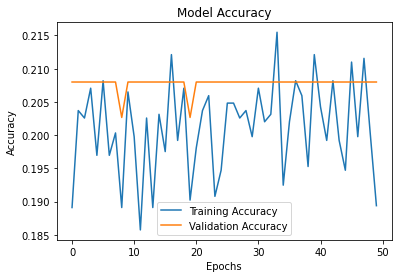

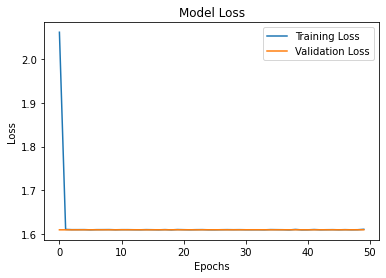

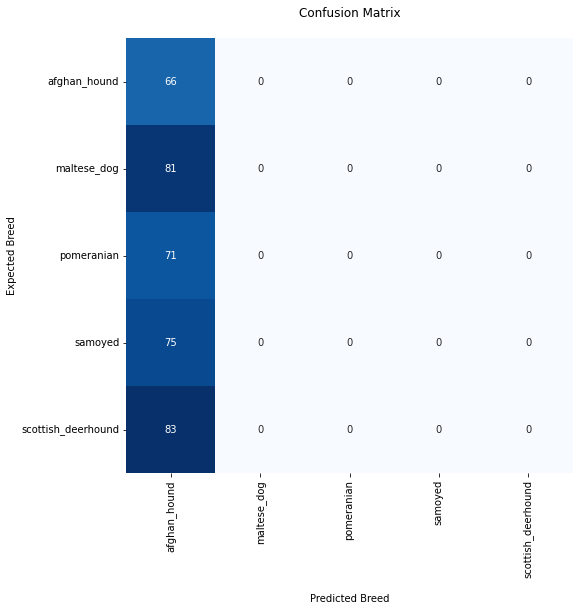




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
epochs = 50
batch_size = 32

history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    verbose=1
    )

plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

evaluate_model(model, X_test, y_test, lb)

# Amelioration

### Configuration 1


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 custom_config_1 (Sequential  (None, 5)                106964997 
 )                                                               
                                                                 
Total params: 121,679,685
Trainable params: 121,679,685
Non-trainable params: 0
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                         

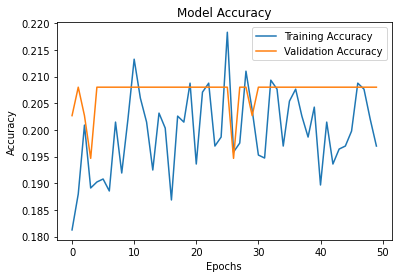

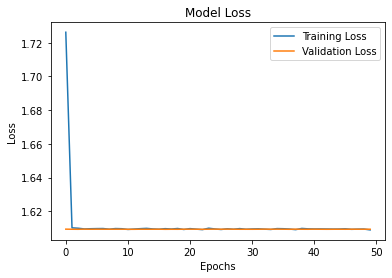

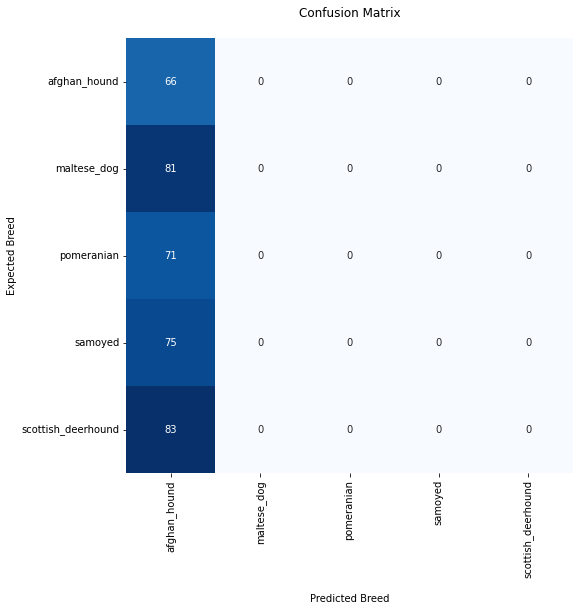




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
model = import_model(conv_model_type='vgg', input_shape=(224, 224, 3), weights=None, train_state=True, custom_model=configuration_1, lr=1e-3)

history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    verbose=1
    )

plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

evaluate_model(model, X_test, y_test, lb)

### Configuration 2

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 custom_config_2 (Sequential  (None, 5)                107091717 
 )                                                               
                                                                 
Total params: 121,806,405
Trainable params: 121,806,405
Non-trainable params: 0
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                         

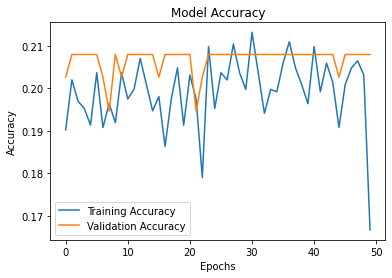

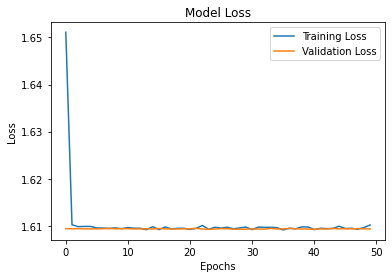

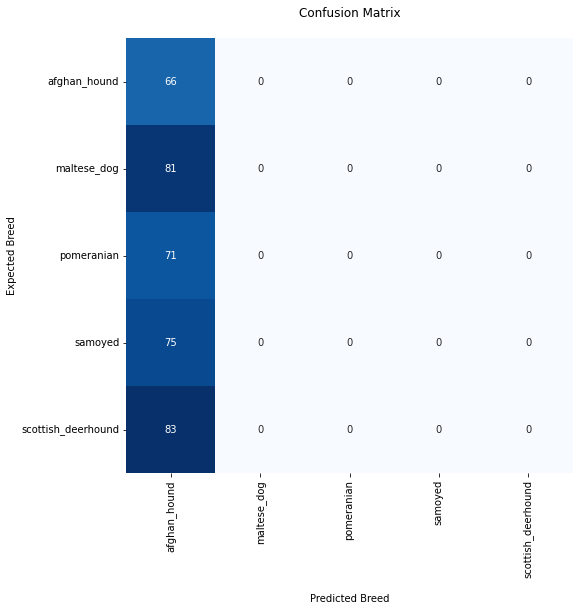




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
model = import_model(conv_model_type='vgg', input_shape=(224, 224, 3), weights=None, train_state=True, custom_model=configuration_2, lr=1e-3)

history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    verbose=1
    )

plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

evaluate_model(model, X_test, y_test, lb)